<a href="https://colab.research.google.com/github/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1/blob/master/RBF%20-%20Radial%20Basis%20Function/codigos/RBF_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/FernandaSzAdr/Redes-Neurais--UFRPE-2019.1.git

Cloning into 'Redes-Neurais--UFRPE-2019.1'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 82 (delta 12), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [0]:
local = 'Redes-Neurais--UFRPE-2019.1/RBF - Radial Basis Function/codigos/'

# Rede Neural de Base Radial (RBF)

In [0]:
!pip install ipdb

import numpy as np
import matplotlib.pyplot as plt

  Stored in directory: /root/.cache/pip/wheels/59/24/91/695211bd228d40fb22dff0ce3f05ba41ab724ab771736233f3
Successfully built ipdb


## Um pouco sobre a teoria...


As redes RBF são redes de alimentação direta (feedforward) consistindo de três camadas:


1.   **Camada de entrada**: propaga os estímulos
2.   **Camada escondida**: Unidades de processamento localmente sintonizáveis, utilizando mapeamento não linear.
3.   **Camada de saída**: Unidades de processamento lineares.


****

**O treinamento dessa rede ocorre de forma híbrida**, combinando aprendizagem não supervisionada (ANS) com a supervisionada(AS). Isso ocorre, pois em geral não se sabe quais saídas se desejam para a camada escondida. Sendo assim, a distribuição de trabalhos ocorre:
*   **ANS**: Treina a camada escondida definindo seus parâmetros livres (centros, larguras dos campos receptivos e pesos).
*   **AS**: Determina os valores dos pesos entre as camadas escondidas e de saída, considerando constantes os parâmetros já definidos.


****

**O aprendizado consiste em** determinar os valores para:
*   centro das funções de base radial,
*   largura das funções,
*   pesos da camada de saída.


Além disso, para cada neurônio da camada escondida, ele computa uma função de base radial.


Os passos necessários são:
1.   Utilizar um algoritmo ANS para encontrar os centros (protótipo para um cluster) das RBF;
2.   Utilizar métodos heurísticos para determinar a largura (área de influência de um cluster) de cada função;
3.   Utilizar um AS para determinar os pesos da camada de saída da rede.


### O código foi retirado do site [Python Machine Learning](https://pythonmachinelearning.pro/using-neural-networks-for-regression-radial-basis-function-networks/)






## Definição da função de base radial

In [0]:
def rbfGaussiana(x, c, s):
  return np.exp(-1 / (2 * s**2) * (x-c)**2)
  
def rbfMultiquadratica(x, c, s):
  return np.sqrt(x**2 + c**2)/c

def rbfMultiquadraticaInversa(x, c, s):
  return c/np.sqrt(x**2 + c**2)

## 1ª Etapa: Inicialização dos grupos com K-Means

In [0]:
def kmeans(X, k):
  
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- vetor de características da entrada
        k {int} -- número de grupos
    
    Returns:
        ndarray -- retorna um array com os centros dos grupos
    """

    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False

    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)

        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)

        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()

    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)

    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])

    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))

    return clusters, stds


## 2ª Etapa - Treinamento de uma Rede Neural

In [0]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=None, inferStds=True):
      self.k = k #grupos
      self.lr = lr 
      self.epochs = epochs  #número de iterações
      self.rbf = rbf  # função de base radial
      self.inferStds = inferStds  #se vai calcular o tamanho do cluster (std)

      self.w = np.random.randn(k)
      self.b = np.random.randn(1)

    def fit(self, X, y):
      if self.inferStds:
        # compute stds from data
        # centros e a área de influência de um cluster
        # cada neuronio possui uma largura própria
        self.centers, self.stds = kmeans(X, self.k)
      else:
        # use a fixed std 
        self.centers, _ = kmeans(X, self.k)
        dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
        # valor unico de largura para todos os neuronios
        self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

      # training
      for epoch in range(self.epochs):
        for i in range(X.shape[0]):
          a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
          F = a.T.dot(self.w) + self.b 
          
          loss = (y[i] - F).flatten() ** 2 
          #print('Loss: {0:.2f}'.format(loss[0]))

          # backward pass
          error = -(y[i] - F).flatten()  # saida desejada - saida obtida 

          # online update
          self.w = self.w - self.lr * a * error  # peso atual - taxa aprendizagem * entrada * erro
          self.b = self.b - self.lr * error

    def predict(self, X):
      y_pred = []
      error = 0
      for i in range(X.shape[0]):
        a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
        F = a.T.dot(self.w) + self.b
        y_pred.append(F)

      return np.array(y_pred)


## Executando a Rede Neural

error:  0.7246898626024048


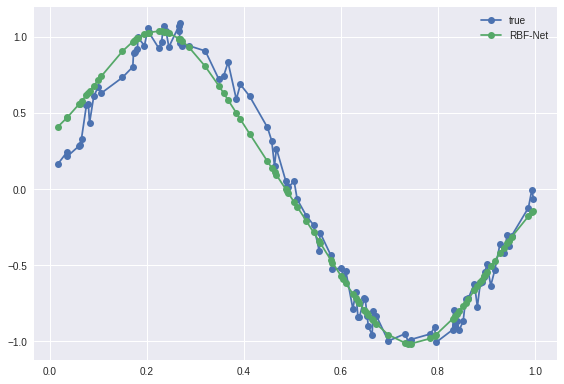

In [0]:
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = RBFNet(lr=1e-2, k=2, rbf=rbfGaussiana, inferStds=True)
rbfnet.fit(X, y)

y_pred = rbfnet.predict(X)

errorabs = abs(y-y_pred)
print('error: ' , np.sum(errorabs[0]/NUM_SAMPLES, axis=0))


plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

# Descrição Mini Projeto

Utilizando o código acima, modifique a última seção (Executando com Base de Dados) para que ele seja executado com a base de dados do arquivo train-mod.csv. Depois, modifique a função de base radial implementada (Gaussiana), para a Multiquadrática e a Multiquadrática Inversa e calcule a taxa de erro.

1 - Calcular o taxa de erro no conjunto de teste na RBF utilizando a base de dados train-mod.csv

2- Calcular a taxa de erro usando 3 funções de Base Radial:
a) Gaussiana
b) Multiquadrática
c) Multiquadrática Inversa


DATA DE ENTREGA: 02/04/2019


### Código baseado em [RBF With Keras](https://medium.com/datadriveninvestor/building-radial-basis-function-network-with-keras-estimating-survivors-of-titanic-a06c2359c5d9)

## Imports e configurações iniciais

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed

In [0]:
data = local + 'train-mod.csv'
kval = 10
itertot = 40
sigma = 1.2
itergd = 300

In [0]:
def transforminput(param, center, function):
  def rbfGaussiana(i, j, sigma):
    return np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
  
  def rbfMultiquadratica(i, j, sigma):
    return np.sqrt(np.sum(np.sum(
           param[i] - center[j])**2.0 + center[j]**2.0))/np.sum(center[j], axis=0)

  def rbfMultiquadraticaInversa(i, j, sigma):
    return np.sum(center[j], axis=0)/np.sqrt(np.sum(
           np.sum(param[i] - center[j])**2.0 + center[j]**2.0))
  
  switcher = {
      'rbfGaussiana': rbfGaussiana,
      'rbfMultiquadratica': rbfMultiquadratica,
      'rbfMultiquadraticaInversa': rbfMultiquadraticaInversa,
  }
  
  newinput = np.zeros((len(param), len(center))).astype('float32')
  for i in range(len(param)):
    for j in range(len(center)):
      fun = switcher.get(function, "nothing")
      newinput[i,j] = fun(i, j, sigma)
  return newinput

In [0]:
def generatemodel(numparam):
  model = Sequential()
  model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

## Normalizando base de dados

In [0]:
dataread = np.genfromtxt(data, delimiter=',')[1:,1:]

alldata = []
for i in range(len(dataread)):
  if np.isnan(dataread[i,-2]):
      continue
  alldata.append(dataread[i])

alldata = np.asarray(alldata)

#dividing data
# 600 primeiros elementos e para cada elemento não pegará a primeira posição
trainparam = alldata[:600,1:]
# 600 primeiros elementos e apenas a primeira posição de cada elemento
trainlabel = alldata[:600,0]
# a partir do elemento 600 ate o ultimo e para cada elemento não pegará a primeira posição
testparam = alldata[600:,1:]
# a partir do elemento 600 ate o ultimo e apenas a primeira posição de cada elemento
testlabel = alldata[600:,0]

###############
#normalization#
###############

# Inicializa os vetores com zeros
std = np.zeros((len(trainparam[0]))).astype('float32')
media = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))

# percorre todos os indices do vetor de caracteristica
# realiza a normalização do vetor de caracteristica
for i in range(len(trainparam[0])):
  std[i] = np.std(trainparam[:,i])
  media[i] = np.mean(trainparam[:,i])
  trainparamnorm[:,i] = (trainparam[:,i] - media[i]) / std[i]
  testparamnorm[:,i] = (testparam[:,i] - media[i]) / std[i]


## Gaussiana

### K-means

In [40]:
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
  for j in range(len(kmean[0])):
    kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
    
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
  print('iterasi ke', i)
  for j in range(len(distmin)):
    #determine euclid distance
    distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
    distmin[j] = np.argmin(distall)
    
#search new k mean
for j in range(kval):
  clust = []
  for k in range(len(distmin)):
    if distmin[k] == j:
      clust.append(trainparamnorm[k])
    if len(clust) > 0:
      kmean[j] = np.mean(np.asarray(clust), axis=0)

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39


### Treinando a rede

In [41]:
newinput = transforminput(trainparamnorm, kmean, 'rbfGaussiana')

mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)

Epoch 1/300
600/600 [==============================] - 0s 490us/step - loss: 0.6780 - acc: 0.5833
Epoch 2/300
600/600 [==============================] - 0s 173us/step - loss: 0.6762 - acc: 0.5950
Epoch 3/300
600/600 [==============================] - 0s 173us/step - loss: 0.6745 - acc: 0.5950
Epoch 4/300
600/600 [==============================] - 0s 203us/step - loss: 0.6731 - acc: 0.5950
Epoch 5/300
600/600 [==============================] - 0s 174us/step - loss: 0.6718 - acc: 0.5950
Epoch 6/300
600/600 [==============================] - 0s 174us/step - loss: 0.6707 - acc: 0.5950
Epoch 7/300
600/600 [==============================] - 0s 174us/step - loss: 0.6695 - acc: 0.5950
Epoch 8/300
600/600 [==============================] - 0s 178us/step - loss: 0.6685 - acc: 0.5950
Epoch 9/300
600/600 [==============================] - 0s 179us/step - loss: 0.6675 - acc: 0.5950
Epoch 10/300
600/600 [==============================] - 0s 177us/step - loss: 0.6667 - acc: 0.5950
Epoch 11/300
600/60

### Testando a rede

In [0]:
newinputtest = transforminput(testparamnorm, kmean, 'rbfGaussiana')

lifeprob = mod.predict(newinputtest)

### Erro 


In [43]:
binpred = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
  if lifeprob[i] > 0.5:
    binpred[i] = 1.

score = 0
for i in range(len(testlabel)):
  if binpred[i] == testlabel[i]:
    score += 1

errorabs = abs(score-len(lifeprob))
print('error: ' , np.sum(errorabs/len(testlabel), axis=0))

error:  0.2719298245614035


## Multiquadratica

### K-means

In [44]:
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
  for j in range(len(kmean[0])):
    kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
    
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
  print('iterasi ke', i)
  for j in range(len(distmin)):
    #determine euclid distance
    distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
    distmin[j] = np.argmin(distall)
    
#search new k mean
for j in range(kval):
  clust = []
  for k in range(len(distmin)):
    if distmin[k] == j:
      clust.append(trainparamnorm[k])
    if len(clust) > 0:
      kmean[j] = np.mean(np.asarray(clust), axis=0)

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39


### Treinando a rede

In [45]:
newinput = transforminput(trainparamnorm, kmean, 'rbfMultiquadratica')

mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)

Epoch 1/300
600/600 [==============================] - 0s 513us/step - loss: 1.1391 - acc: 0.4067
Epoch 2/300
600/600 [==============================] - 0s 201us/step - loss: 0.8401 - acc: 0.4017
Epoch 3/300
600/600 [==============================] - 0s 171us/step - loss: 0.7293 - acc: 0.4683
Epoch 4/300
600/600 [==============================] - 0s 195us/step - loss: 0.7006 - acc: 0.5683
Epoch 5/300
600/600 [==============================] - 0s 182us/step - loss: 0.6851 - acc: 0.5967
Epoch 6/300
600/600 [==============================] - 0s 177us/step - loss: 0.6718 - acc: 0.6233
Epoch 7/300
600/600 [==============================] - 0s 175us/step - loss: 0.6589 - acc: 0.6383
Epoch 8/300
600/600 [==============================] - 0s 178us/step - loss: 0.6464 - acc: 0.6617
Epoch 9/300
600/600 [==============================] - 0s 173us/step - loss: 0.6351 - acc: 0.6700
Epoch 10/300
600/600 [==============================] - 0s 179us/step - loss: 0.6244 - acc: 0.6933
Epoch 11/300
600/60

### Testando a rede

In [0]:
newinputtest = transforminput(testparamnorm, kmean, 'rbfMultiquadratica')

lifeprob = mod.predict(newinputtest)

### Erro 


In [47]:
binpred = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
  if lifeprob[i] > 0.5:
    binpred[i] = 1.

score = 0
for i in range(len(testlabel)):
  if binpred[i] == testlabel[i]:
    score += 1

errorabs = abs(score-len(lifeprob))
print('error: ' , np.sum(errorabs/len(testlabel), axis=0))

error:  0.24561403508771928


## MultiquadraticaInversa

### K-means

In [48]:
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
  for j in range(len(kmean[0])):
    kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
    
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
  print('iterasi ke', i)
  for j in range(len(distmin)):
    #determine euclid distance
    distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
    distmin[j] = np.argmin(distall)
    
#search new k mean
for j in range(kval):
  clust = []
  for k in range(len(distmin)):
    if distmin[k] == j:
      clust.append(trainparamnorm[k])
    if len(clust) > 0:
      kmean[j] = np.mean(np.asarray(clust), axis=0)

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39


### Treinando a rede

In [49]:
newinput = transforminput(trainparamnorm, kmean, 'rbfMultiquadraticaInversa')

mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)

Epoch 1/300
600/600 [==============================] - 0s 574us/step - loss: 0.7458 - acc: 0.4067
Epoch 2/300
600/600 [==============================] - 0s 173us/step - loss: 0.7183 - acc: 0.4067
Epoch 3/300
600/600 [==============================] - 0s 181us/step - loss: 0.6971 - acc: 0.4067
Epoch 4/300
600/600 [==============================] - 0s 180us/step - loss: 0.6797 - acc: 0.4717
Epoch 5/300
600/600 [==============================] - 0s 175us/step - loss: 0.6666 - acc: 0.6317
Epoch 6/300
600/600 [==============================] - 0s 184us/step - loss: 0.6560 - acc: 0.7417
Epoch 7/300
600/600 [==============================] - 0s 179us/step - loss: 0.6479 - acc: 0.7733
Epoch 8/300
600/600 [==============================] - 0s 179us/step - loss: 0.6417 - acc: 0.7517
Epoch 9/300
600/600 [==============================] - 0s 222us/step - loss: 0.6373 - acc: 0.7433
Epoch 10/300
600/600 [==============================] - 0s 172us/step - loss: 0.6327 - acc: 0.7367
Epoch 11/300
600/60

### Testando a rede

In [0]:
newinputtest = transforminput(testparamnorm, kmean, 'rbfMultiquadraticaInversa')

lifeprob = mod.predict(newinputtest)

### Erro 


In [51]:
binpred = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
  if lifeprob[i] > 0.5:
    binpred[i] = 1.

score = 0
for i in range(len(testlabel)):
  if binpred[i] == testlabel[i]:
    score += 1

errorabs = abs(score-len(lifeprob))
print('error: ' , np.sum(errorabs/len(testlabel), axis=0))

error:  0.2543859649122807
